# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

pd.options.mode.chained_assignment = None

In [2]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')

df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

### Шаг 2. Предобработка и исследовательский анализ данных

In [3]:
df_train.duplicated().sum()
df_test.duplicated().sum()

0

Дубликатов нет, это позитивно.

In [4]:
display(df_train.tail(15))
#Столбец id удалить хотелось, пока не заглянул в tail и не увидел, что они не дублируют первый столбец, который без названия

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
65214,84008,0,258.0,2016,December,53,28,2,5,1.0,...,0,0,0,B,2,0,Transient,0,3,7
65215,84009,0,259.0,2016,December,53,28,2,5,2.0,...,0,0,0,B,3,0,Transient,0,3,7
65216,84012,0,259.0,2016,December,53,28,2,5,2.0,...,0,0,0,A,3,0,Transient,0,3,7
65217,84014,0,14.0,2016,December,53,28,2,5,2.0,...,0,0,0,A,0,0,Transient,0,1,7
65218,84015,0,291.0,2016,December,53,28,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7
65219,84016,0,42.0,2016,December,53,31,2,2,2.0,...,0,0,0,A,1,0,Transient,0,1,4
65220,84022,0,23.0,2016,December,53,30,2,3,2.0,...,0,0,0,D,1,0,Transient,0,3,5
65221,84023,0,42.0,2016,December,53,29,2,5,2.0,...,0,0,0,E,0,0,Transient,0,0,7
65222,84050,0,96.0,2016,December,53,31,2,3,2.0,...,0,0,0,A,0,0,Transient,0,0,5
65223,84056,0,23.0,2016,December,53,30,2,4,2.0,...,0,0,0,D,0,0,Transient,0,2,6


In [5]:
df_train['lead_time'].unique()
df_test['lead_time'].unique()

array([ 74.,  62.,  71., 172.,  52., 143.,  21.,  89.,  48.,  31.,  20.,
       173.,  23.,  46., 149.,  44.,  68.,   6.,  43., 112.,  59.,  93.,
         4., 115., 187.,  11.,   2.,  15.,  66., 113., 125., 161., 154.,
         1.,   0.,  35.,  37.,  60., 129.,  78.,  10.,  82.,   8.,  22.,
        33., 108.,  87., 106.,  45.,  40.,  17.,   5.,  16.,   3.,  41.,
       135., 123., 128.,  47.,  12., 124., 160.,  58.,  65., 281.,  24.,
        30.,  27.,   9.,  94., 219.,  84.,  79.,  72.,  36., 292., 186.,
        85., 169., 166.,  28.,  83., 111.,  54., 200.,  80., 102.,  95.,
       170., 307., 298.,  55.,  77.,  32.,  25., 238.,   7.,  19., 211.,
       137.,  39.,  18., 206.,  42., 179., 205., 142.,  38.,  92.,  56.,
        29., 119.,  73., 320.,  34., 127.,  69.,  13., 140.,  14., 164.,
        51.,  70., 120.,  76., 105.,  50., 191.,  26.,  75., 116., 184.,
        53.,  49.,  63., 194., 167., 312., 171., 218.,  86., 100., 146.,
        64., 148.,  81.,  88.,  57., 339., 332., 13

Убедились, что все значения в lead_time целочисленные, можно поменять тип данных на соответствующий. Проверим еще и "вещественные" исчисления людей от мала до велика - adults, children & babies.

In [6]:
df_train['adults'].unique()
df_train['children'].unique()
df_train['babies'].unique()
df_train['babies'].value_counts()

0.0     64777
1.0       447
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

Все значения целые, но напрягают 9-10 babies. Обрежем тренировочный датафрейм на эти две строчки. В тестовом таких проблем нет. Заменим все значения на целочисленные:

In [7]:
df_train = df_train.loc[df_train['babies'] <= 2]

df_test['babies'].unique()

df_test['children'].unique()
df_train['lead_time'] = df_train['lead_time'].astype('int')
df_test['lead_time'] = df_test['lead_time'].astype('int')
df_train['adults'] = df_train['adults'].astype('int')
df_test['adults'] = df_test['adults'].astype('int')
df_train['children'] = df_train['children'].astype('int')
df_test['children'] = df_test['children'].astype('int')
df_train['babies'] = df_train['babies'].astype('int')
df_test['babies'] = df_test['babies'].astype('int')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65227 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65227 non-null  int64 
 1   is_canceled                     65227 non-null  int64 
 2   lead_time                       65227 non-null  int64 
 3   arrival_date_year               65227 non-null  int64 
 4   arrival_date_month              65227 non-null  object
 5   arrival_date_week_number        65227 non-null  int64 
 6   arrival_date_day_of_month       65227 non-null  int64 
 7   stays_in_weekend_nights         65227 non-null  int64 
 8   stays_in_week_nights            65227 non-null  int64 
 9   adults                          65227 non-null  int64 
 10  children                        65227 non-null  int64 
 11  babies                          65227 non-null  int64 
 12  meal                            65227 non-null

In [8]:
df_train['meal'].value_counts()
df_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

Кажется, у нас лишние пробелы в параметрах включенного в бронь питания. Удалим все пробелы из этих столбцов.

In [9]:
df_train['meal'] = df_train['meal'].str.strip()
df_train['meal'].value_counts()

df_test['meal'] = df_test['meal'].str.strip()
df_test['meal'].value_counts()

BB    24684
SC     5293
HB     2399
FB       36
Name: meal, dtype: int64

In [10]:
df_train['arrival_date_month'].value_counts()

October      9254
September    8782
August       6678
November     5761
July         5718
December     5497
April        4804
May          4677
June         4659
March        4148
February     3358
January      1891
Name: arrival_date_month, dtype: int64

In [11]:
df_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [12]:
print(df_train['country'].value_counts().head(40))

PRT    28830
FRA     5974
GBR     5108
ESP     4900
DEU     3887
ITA     2327
IRL     1445
BEL     1245
NLD     1166
BRA     1088
USA     1008
CHE      874
AUT      716
SWE      544
POL      531
CHN      526
CN       488
ISR      375
RUS      296
NOR      261
ROU      249
FIN      241
DNK      201
TUR      169
AUS      168
AGO      140
LUX      134
MAR      125
HUN      121
JPN      117
CZE      112
ARG      107
IND       88
SRB       81
GRC       81
KOR       68
DZA       62
HRV       54
IRN       52
THA       48
Name: country, dtype: int64


Очень интересная графа с увлекательными кодами. 
Скорее всего, это коды ISO 
<a href = "https://laendercode.net/en/">Codes</a></div>

Но выделяется TMP (гугл подсказывает, что это временный код Восточного Тимора, заведомо небольшой (статистически вряд ли значимой) территории, и особенно CN, который, вероятно, 2-буквенный аналог CHN (Китая). Среди 2-х и 3-хбуквенных обозначений ISO буквосочетание "CN" встречается, помимо Китая, только у островов Питкэрн, но вряд ли оттуда столько же туристов, сколько из Китая/Израиля/Польши (соседних по таблице выше стран). Делаем вывод, что CN = CHN и соединяем их в одно.

Судя по топу таблицы, предположу, что данные собирались по Португалии (максимальное количество туристов - внутренний туризм, затем страны западной Европы, США и Китай, что логично, но высоко расположены Бразилия (португалоговорящая страна) и в топ-30 также выделяются Ангола (еще одна португалоговорящая) и Марокко (по сути, соседи через Гибралтар). А если расширить до топ-40, добавится еще соседний Алжир (DZA). 

In [13]:
df_train['country'] = df_train['country'].replace('CN', 'CHN')
df_train['country'].value_counts().head(20)
df_test['country'].value_counts().head(20)
df_test['country'] = df_test['country'].replace('CN', 'CHN')
df_test['country'].value_counts().head(20)

PRT    9887
GBR    3927
FRA    3477
DEU    2378
ESP    1932
ITA    1153
IRL    1060
BEL     882
BRA     881
CHN     864
USA     774
NLD     709
CHE     602
AUT     439
SWE     318
ISR     264
NOR     242
POL     239
RUS     217
DNK     182
Name: country, dtype: int64

В остальных столбцах типа object существенных проблем не выявлено.

In [14]:
df_train['distribution_channel'].unique()
df_train['customer_type'].unique()
df_train['reserved_room_type'].unique() #опять пробелы, но анализу они, кажется, не должны помешать. а вот при расчете прибыли помешали, убираю)
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_train['reserved_room_type'].unique()
df_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

In [15]:
df_train.describe()
# выходит, отменяют бронь 36,9% клиентов?

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000,65227.000000
mean,43544.011345,0.368620,96.340135,2015.719027,31.340043,15.847946,0.825180,2.224815,1.836586,0.074892,0.006945,0.027151,0.128919,0.107716,0.194245,3.334524,0.056648,0.512763,3.049995
std,25615.123796,0.482434,96.128157,0.449478,13.463709,8.748283,0.853472,1.355004,0.480241,0.334248,0.083599,0.162526,0.965340,1.326658,0.593830,18.239876,0.232098,0.752597,1.738130
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19107.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.500000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,2.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Из любопытного в цифрах:
- достаточно высокий разброс (std) по времени бронирования - 96 дней. Первый квартиль - 17 дней, 3й - 151. То есть довольно часто бронируют сильно заранее, даже раньше, чем за год, и разбросы в этих числах большие.

Смущают строки с бронированиями, совершенными без участия взрослых. Даже если предположить, что возможно, что семья с большим количеством детей бронирует несколько номеров, в т.ч. отдельный для больших подростков, с точки зрения системы бронирования и законодательства это выглядит странно, поэтому лучше уберем такие строки.

In [16]:
df_train.query('adults == 0')
df_test.query('adults == 0')

df_train = df_train.query('adults != 0')
df_train
df_test = df_test.query('adults != 0')
df_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62,2017,January,1,1,2,2,2,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71,2017,January,1,1,2,2,1,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172,2017,January,1,1,2,5,2,...,0,0,0,A,0,0,Transient,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,...,0,0,0,A,0,0,Transient,0,0,6
32408,97900,0,21,2017,August,35,30,2,5,2,...,0,0,0,A,0,0,Transient,0,2,7
32409,97901,0,23,2017,August,35,30,2,5,2,...,0,0,0,A,0,0,Transient,0,0,7
32410,97902,0,34,2017,August,35,31,2,5,2,...,0,0,0,D,0,0,Transient,0,4,7


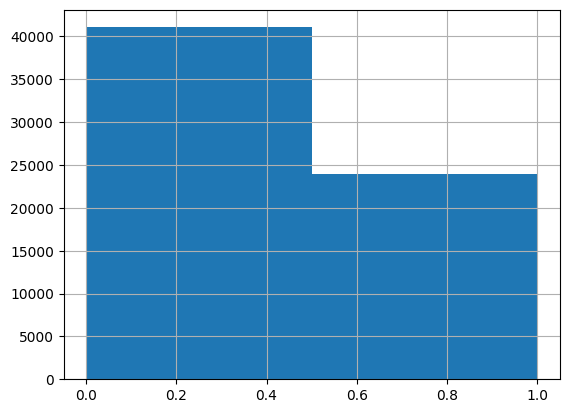

In [17]:
df_train['is_canceled'].hist(bins=2)
plt.show()


Распределение целевого признака: отменены почти 25000 броней из 63 тысяч.

#### EDA
Нас интересует взаимосвязь разнообразных признаков с отменой брони клиентом, поэтому постараемся в рамках EDA эту взаимосвязь увидеть.

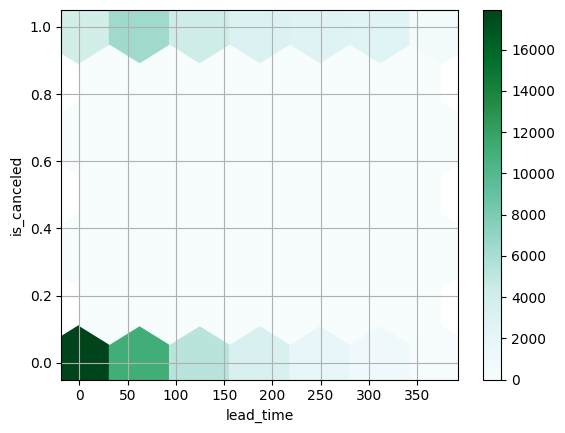

0.32859604709635837


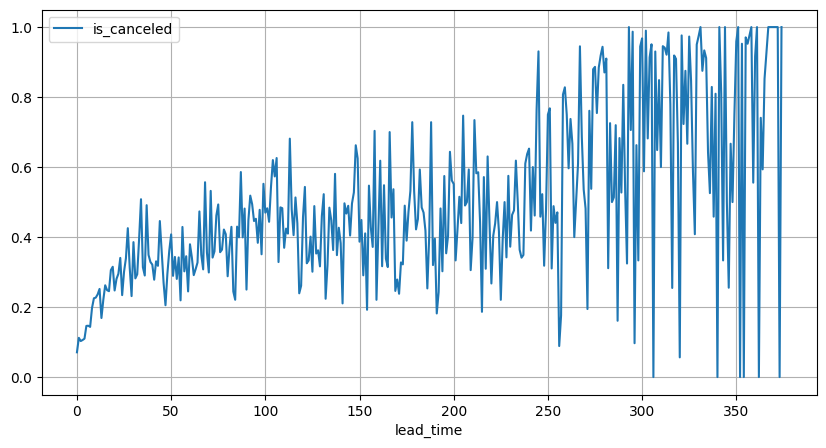

In [18]:
df_train.plot(x='lead_time', y='is_canceled', kind='hexbin', gridsize=6, sharex=False, grid=True)
plt.show()

print(df_train['lead_time'].corr(df_train['is_canceled']))
df_train.pivot_table(index='lead_time', values='is_canceled').plot(grid=True, figsize=(10,5))
plt.show()

1) корреляция времени бронирования и риска отмены брони есть, но ее коэффициент достаточно низкий (0,33). На графике видим, что брони до 20 дней отменяются крайне редко. По диаграмме hexbin кажется, что самый высокий риск отмены почему-то у броней, сделанных за 20-90 дней до заезда, но график через pivot_table со средними значениями это не подтверждает. Зато видим, что сделанные сильно заранее (от 250 дней) брони чаще "пикуют" у единицы (отмена брони), чем у нуля. Полагаю, что такие резкие пики из-за малого количества бронирований с разным количеством lead_time от 250 и выше дней, поэтому и средние значения по этим дням сильнее разбросаны. Но тенденция с ростом видна (что и подтверждается слабой, но корреляцией).


-0.03069795414402434


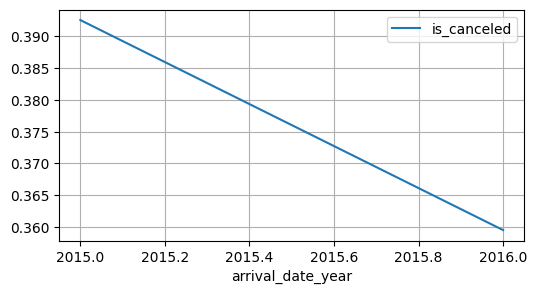

In [19]:
print(df_train['arrival_date_year'].corr(df_train['is_canceled']))

df_train.pivot_table(index='arrival_date_year', values='is_canceled').plot(grid=True, figsize=(6,3))
plt.show()

2) с годом заезда взаимосвязь увидеть сложно, в 2016 просто больше броней вообще и отмененных в частности. Разница на диаграмме по средним значениям также несущественная.

0.012751181495991295


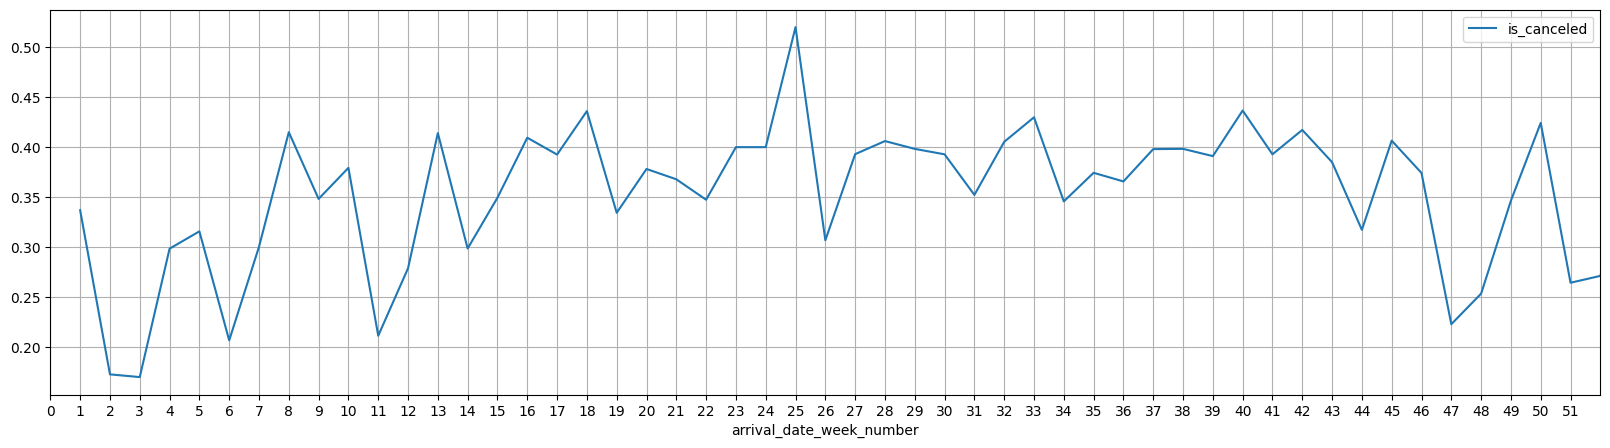

In [20]:
print(df_train['arrival_date_week_number'].corr(df_train['is_canceled']))
df_train.pivot_table(index='arrival_date_week_number', values='is_canceled').plot(grid=True, figsize=(20,5), xlim=(0,52)).set_xticks(range(0, 52))
plt.show()


3) редко отменяются брони в начале года (2-4 недели). При заезде на 25й неделе (середина/конец июня) отменяется каждая вторая бронь, но значение резко падает на 26й неделе, поэтому скорее статистическая погрешность, чем явная тенденция. Зато в пике на 50й неделе можно усмотреть рождественские каникулы, это недалеко от 25 декабря.

-0.0018107183807303804


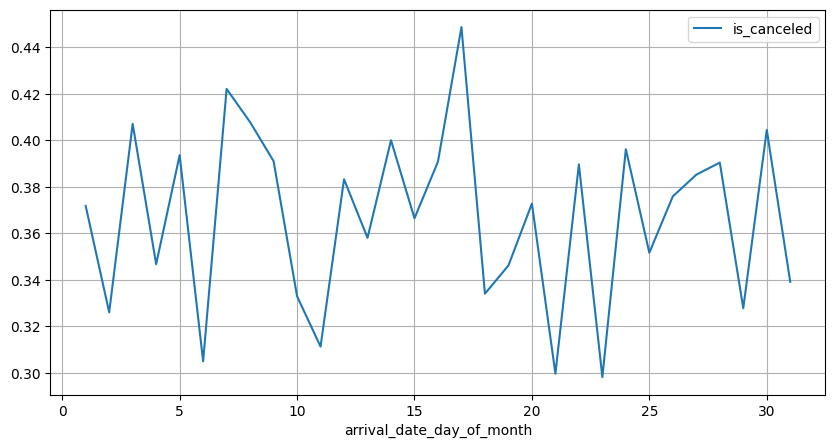

In [21]:
print(df_train['arrival_date_day_of_month'].corr(df_train['is_canceled']))

df_train.pivot_table(index='arrival_date_day_of_month', values='is_canceled').plot(grid=True, figsize=(10,5))
plt.show()

4) реже всего отменяются брони с заездом 6, 11, 21 и 23 числа. Чаще всего - с заездом 17го числа месяца. Но какие-то выводы по этим данным тяжело делать. 

-0.013851908699453904


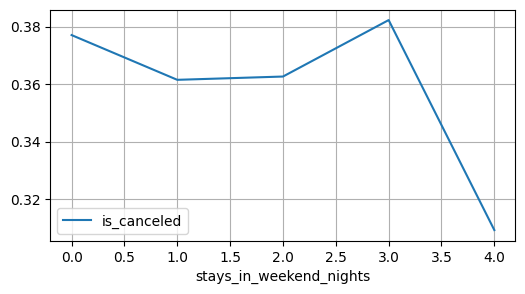

In [22]:
print(df_train['stays_in_weekend_nights'].corr(df_train['is_canceled']))

df_train.pivot_table(index='stays_in_weekend_nights', values='is_canceled').plot(grid=True, figsize=(6,3))
plt.show()

По pivot_table можно сделать вывод, что чуть меньше риск отмены брони, если она захватывает 4 дня уикенда (т.е. продолжается от 9 дней). Но разница значений по оси Y кажется незначительной.

0.010439381717932874


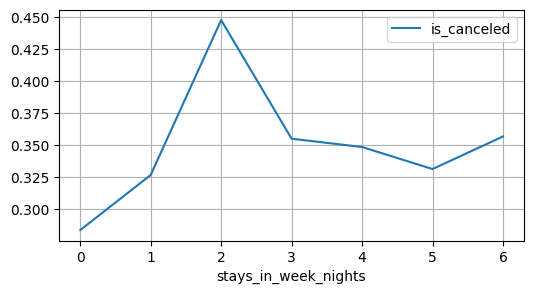

In [23]:
print(df_train['stays_in_week_nights'].corr(df_train['is_canceled']))
df_train.pivot_table(index='stays_in_week_nights', values='is_canceled').plot(grid=True, figsize=(6,3))
plt.show()

Отменяется почти каждая вторая бронь на 2 будних дня. Реже всего отменяются брони на выходные, не затрагивающие будни. 

0.04441823299426236
-0.017192923445698234
-0.032443484327085756


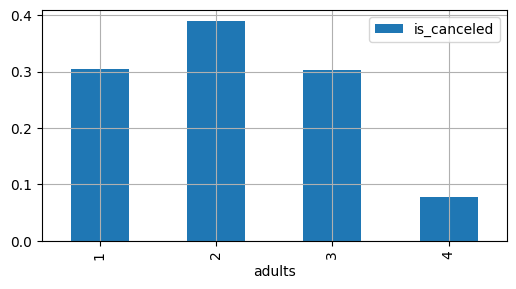

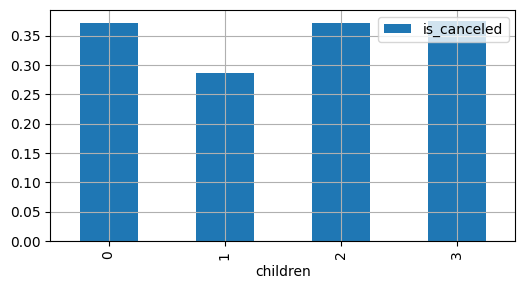

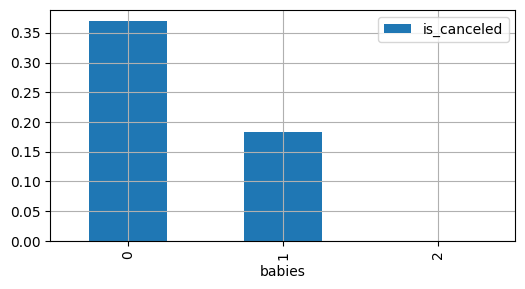

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
7390,9778,0,174,2015,September,36,2,1,4,2,...,0,0,0,C,1,0,Transient,1,2,5
15516,18273,0,47,2016,November,45,5,2,2,2,...,0,0,0,A,1,0,Transient,0,5,4
56050,74658,0,4,2016,July,31,27,0,4,2,...,0,0,0,D,2,0,Transient,0,2,4


In [24]:
print(df_train['adults'].corr(df_train['is_canceled']))
df_train.pivot_table(index='adults', values='is_canceled').plot(kind='bar', grid=True, figsize=(6,3))

print(df_train['children'].corr(df_train['is_canceled']))
df_train.pivot_table(index='children', values='is_canceled').plot(kind='bar', grid=True, figsize=(6,3))
print(df_train['babies'].corr(df_train['is_canceled']))
df_train.pivot_table(index='babies', values='is_canceled').plot(kind='bar', grid=True, figsize=(6,3))
plt.show()

df_train.query('babies == 1')
df_train.query('babies == 2')

Взрослые: почти не отменяются брони с 4 взрослыми. С двумя взрослыми в бронировании — отменяется почти каждая вторая.

Дети: Разница небольшая, но с одним ребенком шансов на отмену чуть меньше.

Младенцы: на 450 бронирований ни одной отмены с двумя младенцами, но всего 3 таких случая. С одним младенцем отменяют меньше, чем без них.

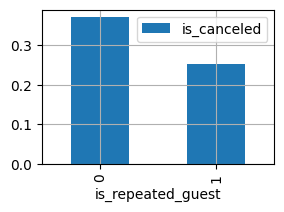

-0.04030313264166835


In [25]:
df_train.pivot_table(index='is_repeated_guest', values='is_canceled').plot(kind='bar', grid=True, figsize=(3,2))
plt.show()
print(df_train['is_repeated_guest'].corr(df_train['is_canceled']))


По возвращающимся гостям статистика простая: если бронирует не впервые, то и отменяет реже.

0.1531263528446997


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6273,8602,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6274,8603,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6275,8604,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6276,8605,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6277,8606,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6278,8607,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6279,8608,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6280,8609,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6281,8610,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2
6282,8611,1,275,2015,October,41,4,2,0,2,...,0,26,0,A,0,0,Transient,0,0,2


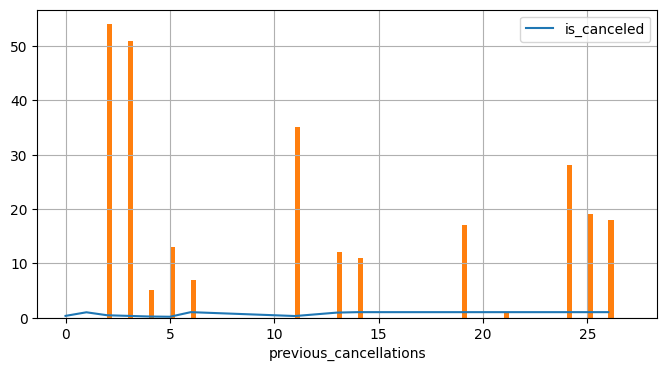

In [26]:
df_train.pivot_table(index='previous_cancellations', values='is_canceled').plot(grid=True, figsize=(8,4))
print(df_train['previous_cancellations'].corr(df_train['is_canceled']))
display(df_train.query('previous_cancellations >= 10').head(25))

df_train['previous_cancellations'].describe()
df_train['previous_cancellations'].hist(bins=100, range=(2, 27))
plt.show()

Казалось бы, вывод простой: если клиент отменял бронь уже более 11 раз, то наверняка отменит и эту. По факту же видим в срезе наборы очень похожих строчек. Что, если это на самом деле дубликаты, просто с разными ID?
По гистограмме именно по столбцу previous_cancellations, не принимая во внимание столбцы со значениями 0 и 1, нет ощущения, что данные странные.

count    65061.000000
mean         0.193449
std          0.592182
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: booking_changes, dtype: float64
AxesSubplot(0.125,0.11;0.775x0.77)
-0.14271871352743842


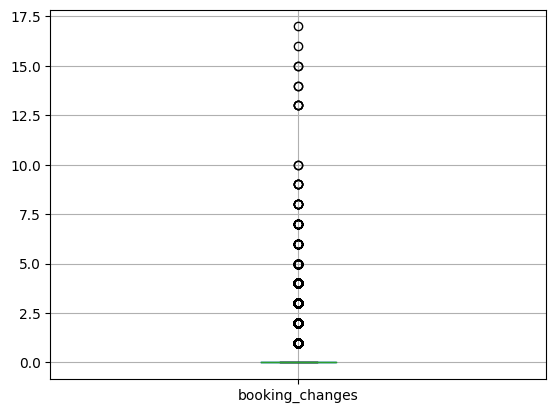

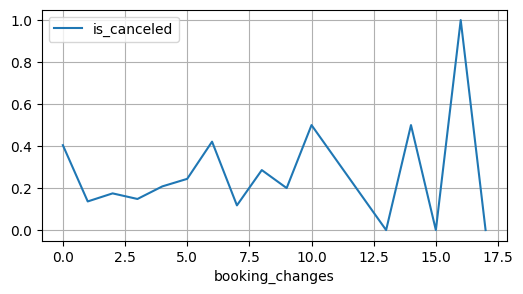

In [27]:
df_train.boxplot(column='booking_changes')
print(df_train['booking_changes'].describe())
print(df_train.pivot_table(index='booking_changes', values='is_canceled').plot(grid=True, figsize=(6,3)))

print(df_train['booking_changes'].corr(df_train['is_canceled']))

Столбец booking_changes, по сути, целиком представляет из себя выброс. И на статистику отмен значительным и/или очевидным образом не влияет.

0.0013393627278454185


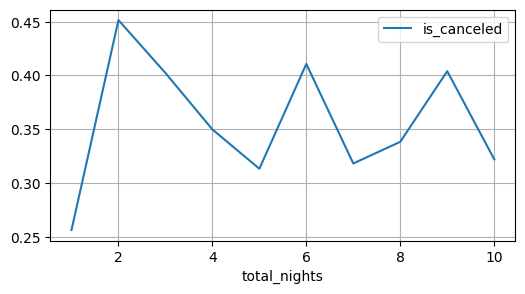

In [28]:
df_train.pivot_table(index='total_nights', values='is_canceled').plot(grid=True, figsize=(6,3))
print(df_train['total_nights'].corr(df_train['is_canceled']))


Бронирования на одну ночь отменяются реже всего; на 2, 6 и 9 ночей - чаще (почти половина из них).

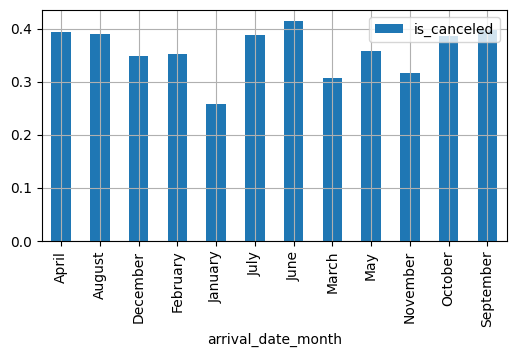

October      9238
September    8771
August       6647
November     5750
July         5701
December     5478
April        4795
May          4667
June         4651
March        4138
February     3344
January      1881
Name: arrival_date_month, dtype: int64

In [29]:
df_train.pivot_table(index='arrival_date_month', values='is_canceled').plot(kind='bar', grid=True, figsize=(6,3))
plt.show()
df_train['arrival_date_month'].value_counts()

Меньший процент отмен у броней на январь, но там и общее количество бронирований минимальное. Наивысший - у соседних июня, июля, а также сентября (последнего по алфавиту), августа (непредсказуемый сезон отпусков) и апреля (пасхальные каникулы?). То есть можно предположить, что туристы-отпускники меняют свои планы чаще, чем останавливающиеся в отелях в другие времена года, вероятно, больше по работе.

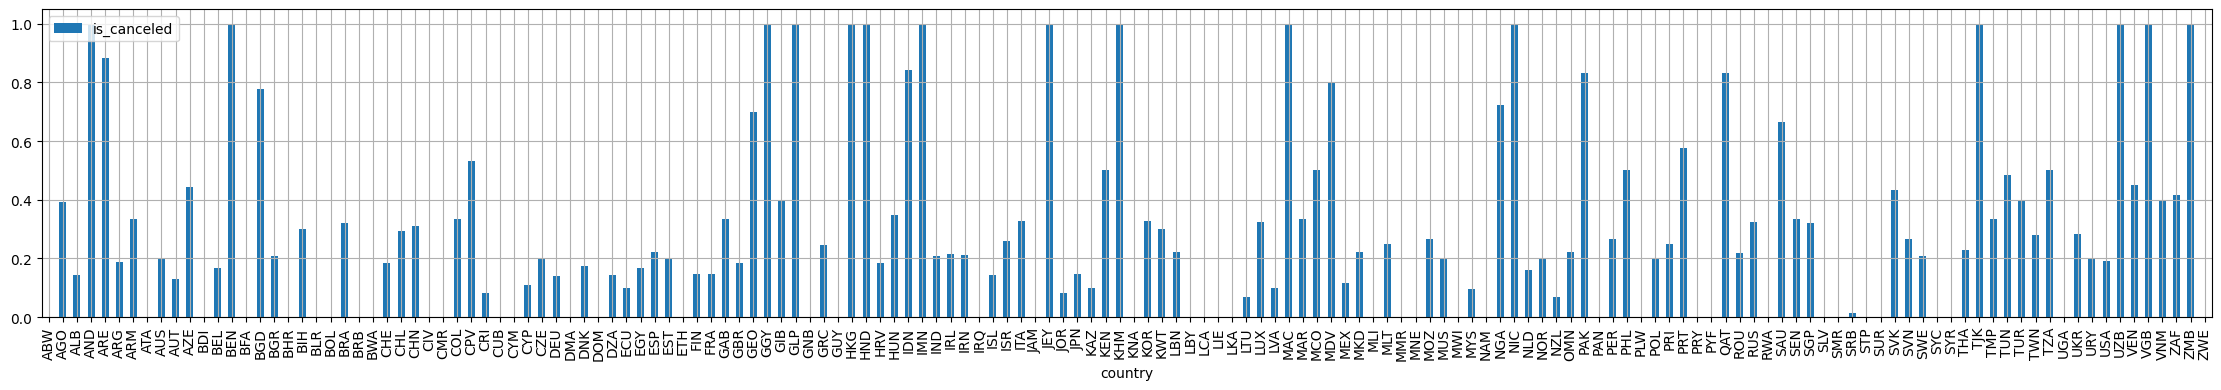

In [30]:
df_train.pivot_table(index='country', values='is_canceled').plot(kind='bar', grid=True, figsize=(28,4))
plt.show()

График получился неинформативным, так как во многих странах отмен броней не было/отменены все брони - полагаю, что дело в количество броней по странам. 

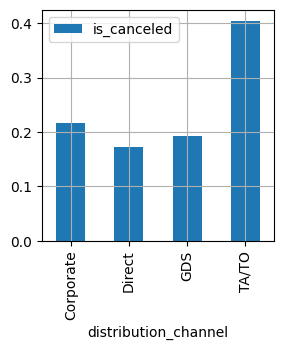

TA/TO        54310
Direct        6831
Corporate     3821
GDS             99
Name: distribution_channel, dtype: int64

In [31]:
df_train.pivot_table(index='distribution_channel', values='is_canceled').plot(kind='bar', grid=True, figsize=(3,3))
plt.show()
df_train['distribution_channel'].value_counts()

Как подсказал гугл, TA/TO = tour agencies/tour operators, турагентства. Именно через них больше всего бронирований совершается, но 40% из них отменяются. И только каждая пятая бронь, сделанная через другие каналы бронирования.

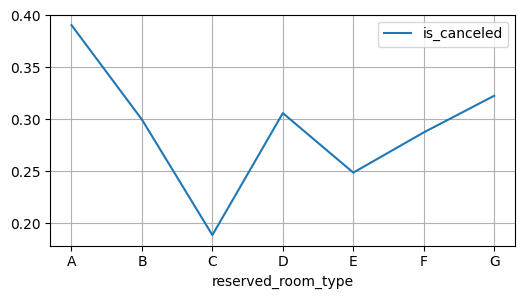

A    50487
D     9384
E     2445
F     1211
B      714
G      592
C      228
Name: reserved_room_type, dtype: int64

In [32]:
df_train.pivot_table(index='reserved_room_type', values='is_canceled').plot(grid=True, figsize=(6,3))
plt.show()
df_train['reserved_room_type'].value_counts()

Здесь гугл не подскажет, что имеется в виду под каждой из букв, обозначающих типы комнат. Но снова наивысший процент отмен там, где наивысшее количество бронирований (тип А, по условиям проекта - самый дорогой тип). Примерно каждая третья бронь отменяется по комнатам типов B, D & G. Самый "надежный" тип - E. (С не рассматриваем из-за малого количества бронирований).

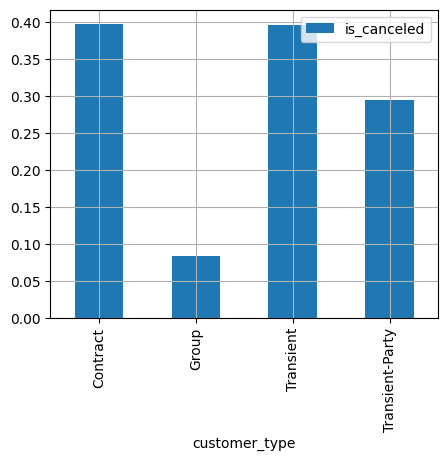

Transient          45401
Transient-Party    16629
Contract            2745
Group                286
Name: customer_type, dtype: int64

In [33]:
df_train.pivot_table(index='customer_type', values='is_canceled').plot(kind='bar', grid=True, figsize=(5,4))
plt.show()
df_train['customer_type'].value_counts()

Вывод: не доверяйте договорам с юридическими лицами, они отменяют 40% обещанных заездов. Как, впрочем, и заказчик типа Transient, которых еще и существенно больше остальных. 

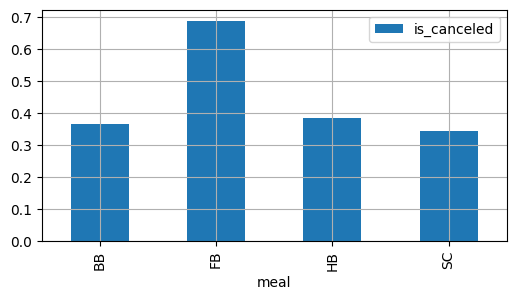

BB    51544
HB     7289
SC     5777
FB      451
Name: meal, dtype: int64

In [34]:
df_train.pivot_table(index='meal', values='is_canceled').plot(kind='bar', grid=True, figsize=(6,3))
plt.show()
df_train['meal'].value_counts()

Отменяется рекордное количество бронирований с полным пансионом, но надо учитывать, что доля их от общего количества составляет меньше 1%. 

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Вспомним условия от заказчика:

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:

    категория A: за ночь — 1 000, разовое обслуживание — 400;
    категория B: за ночь — 800, разовое обслуживание — 350;
    категория C: за ночь — 600, разовое обслуживание — 350;
    категория D: за ночь — 550, разовое обслуживание — 150;
    категория E: за ночь — 500, разовое обслуживание — 150;
    категория F: за ночь — 450, разовое обслуживание — 150;
    категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Создадим новые столбцы с учётом этих данных. Для этого создадим словари с коэффициентами по временам года и категориям комнат, после чего напишем функцию для строки, которая посчитает прибыль для каждого бронирования или отмены.

In [35]:
season_dict = pd.DataFrame({'arrival_date_month' : ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
'coef' : [1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1]})
season_dict
rooms_dict = pd.DataFrame({'reserved_room_type' : ['A', 'B', 'C', 'D', 'E', 'F', 'G'], 'room_price' : [1000, 800, 600, 550, 500, 450, 350], 'room_cleaning': [400, 350, 350, 150, 150, 150, 150]})
rooms_dict

hotel_revenues = df_test.merge(season_dict, on='arrival_date_month', how='left')
hotel_revenues = hotel_revenues.merge(rooms_dict, on='reserved_room_type', how='left')
hotel_revenues

def rev(row):
       
    for i in range(len(row)):
        if row['is_canceled'] == 0:
            row['revenue'] = row['room_price'] * row['total_nights'] * row['coef'] - (row['room_cleaning']*(1 + math.floor(row['total_nights']/2)))
            return row['revenue']
        elif row['is_canceled'] == 1:
            row['revenue'] = - row['room_price'] * row['coef'] - row['room_cleaning']
            return row['revenue'] 
        
hotel_revenue = hotel_revenues.apply(rev, axis=1).sum()
hotel_revenue


32510590.0

Без введения депозитов за отмену бронирования прибыль отеля составляет 32,5 млн у.е. 

Посчитаем теперь прибыль, если отель введёт депозит в размере 80% от стоимости номера за одни сутки и затрат на разовую уборку для тех, кто отменит бронь.

In [39]:
def dep_rev(row):
 
    for i in range(len(row)):
        if row['is_canceled'] == 0:
            row['deposit_revenue'] = row['room_price'] * row['total_nights'] * row['coef'] - (row['room_cleaning']*(1 + math.floor(row['total_nights']/2)))
            return row['deposit_revenue']
        elif row['is_canceled'] == 1:
            row['deposit_revenue'] = (row['room_price'] * row['coef'] + row['room_cleaning'])*0.8
            return row['deposit_revenue'] 
        
deposit_hotel_revenues = hotel_revenues.apply(dep_rev, axis=1).sum()

deposit_hotel_revenues

64911436.0

Если бы у всех отменивших бронь клиентов был списан депозит, прибыль отеля выросла бы почти вдвое, до 64,9 млн у.е.

### Шаг 4. Разработка модели ML

Выделим целевой признак. А также уберем неинформативные столбцы или те, которые дублируют друг друга.

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65061 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65061 non-null  int64 
 1   is_canceled                     65061 non-null  int64 
 2   lead_time                       65061 non-null  int64 
 3   arrival_date_year               65061 non-null  int64 
 4   arrival_date_month              65061 non-null  object
 5   arrival_date_week_number        65061 non-null  int64 
 6   arrival_date_day_of_month       65061 non-null  int64 
 7   stays_in_weekend_nights         65061 non-null  int64 
 8   stays_in_week_nights            65061 non-null  int64 
 9   adults                          65061 non-null  int64 
 10  children                        65061 non-null  int64 
 11  babies                          65061 non-null  int64 
 12  meal                            65061 non-null

In [41]:
features_train = df_train.drop(['is_canceled', 'id', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_bookings_not_canceled', 'required_car_parking_spaces'], axis = 1)
target_train = df_train['is_canceled']
features_test = df_test.drop(['is_canceled', 'id', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_bookings_not_canceled', 'required_car_parking_spaces'], axis = 1)
target_test = df_test['is_canceled']
features_train.shape
features_test.shape

(32343, 17)

In [42]:
numeric = ['lead_time', 'arrival_date_week_number', 'adults', 'children', 'babies', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'total_nights']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32343 entries, 0 to 32411
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lead_time                  32343 non-null  float64
 1   arrival_date_month         32343 non-null  object 
 2   arrival_date_week_number   32343 non-null  float64
 3   adults                     32343 non-null  float64
 4   children                   32343 non-null  float64
 5   babies                     32343 non-null  float64
 6   meal                       32343 non-null  object 
 7   country                    32343 non-null  object 
 8   distribution_channel       32343 non-null  object 
 9   is_repeated_guest          32343 non-null  int64  
 10  previous_cancellations     32343 non-null  float64
 11  reserved_room_type         32343 non-null  object 
 12  booking_changes            32343 non-null  float64
 13  days_in_waiting_list       32343 non-null  flo

In [44]:
enc = OneHotEncoder(handle_unknown='ignore')
ohe_cat = ['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
enc.fit(features_train[ohe_cat])
ohe_features_train = enc.transform(features_train[ohe_cat])

ohe_features_test = enc.transform(features_test[ohe_cat])
print(ohe_features_train.shape)
print(ohe_features_test.shape)

(65061, 185)
(32343, 185)


Провели стандартизацию столбцов, выраженных числами, и категоризирование столбцов типа object. Количество столбцов в тренировочном и тестовом датафреймах совпадает. Перейдем к обучению и подбору гиперпараметров моделей через RandomSearchCV.

In [49]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 5)]

max_depth = [int(x) for x in np.linspace(1, 10, num = 3)]

max_features = ['auto', 'sqrt']

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}

model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=12345), 
                   param_distributions = rf_grid, 
                   cv = 5, n_iter = 10, scoring='accuracy',verbose=2)

model.fit(ohe_features_train, target_train)
print(model.best_params_)
print(model.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5; total time=   0.1s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5; total time=   0.1s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5; total time=   0.1s
[CV] END max_depth=1, max_features=sqrt, min_samples_leaf=4

In [50]:
estimator = LogisticRegression()

max_iter = np.arange(100, 1000, 300)
solver = ['newton-cg', 'lbfgs', 'liblinear']
warm_start = [True, False]
C = np.arange(0.1, 1, 0.3)

params = {'max_iter': max_iter, 'warm_start': warm_start, 'solver': solver, 'C': C}

random_estimator = RandomizedSearchCV(estimator=estimator, param_distributions=params, n_iter=100, scoring='accuracy', n_jobs=-1, verbose=2, random_state=12345)
random_estimator.fit(ohe_features_train, target_train)
print(random_estimator.best_params_)
print(random_estimator.best_score_)

/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=True; total time=   2.3s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=True; total time=   2.4s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=True; total time=   2.5s


[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=False; total time=   2.9s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=True; total time=   3.0s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=False; total time=   3.1s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=True; total time=   3.3s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=False; total time=   4.4s
[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=False; total time=   2.3s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END .C=0.1, max_iter=100, solver=lbfgs, warm_start=True; total time=   1.7s
[CV] END .C=0.1, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.5s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END C=0.1, max_iter=100, solver=newton-cg, warm_start=False; total time=   3.0s
[CV] END .C=0.1, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.1s
[CV] END .C=0.1, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.3s
[CV] END .C=0.1, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.6s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=True; total time=   1.3s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END C=0.1, max_iter=100, solver=lbfgs, warm_start=False; total time=   1.7s
[CV] END C=0.1, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.2s
[CV] END C=0.1, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.1s[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=True; total time=   1.6s

[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=True; total time=   1.7s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END C=0.1, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.8s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=True; total time=   0.9s
[CV] END C=0.1, max_iter=100, solver=lbfgs, warm_start=False; total time=   3.4s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=True; total time=   1.2s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=False; total time=   1.0s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=False; total time=   1.2s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=False; total time=   1.5s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=False; total time=   1.3s
[CV] END C=0.1, max_iter=100, solver=liblinear, warm_start=False; total time=   1.1s
[CV] END C=0.1, max_iter=400, solver=newton-cg, warm_start=False; total time=   1.9s
[CV] END C=0.1, max_iter=400, solver=newton-cg, warm_start=False; total time=   2.3s
[CV] END C=0.1, max_iter=400, solver=newton-cg, warm_start=True; total time

/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .C=0.4, max_iter=100, solver=lbfgs, warm_start=True; total time=   1.4s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .C=0.4, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.3s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .C=0.4, max_iter=100, solver=lbfgs, warm_start=True; total time=   1.8s
[CV] END C=0.4, max_iter=100, solver=newton-cg, warm_start=False; total time=   3.6s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .C=0.4, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.3s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END .C=0.4, max_iter=100, solver=lbfgs, warm_start=True; total time=   3.0s
[CV] END C=0.4, max_iter=100, solver=lbfgs, warm_start=False; total time=   1.5s
[CV] END C=0.4, max_iter=100, solver=lbfgs, warm_start=False; total time=   1.7s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.4, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.9s
[CV] END C=0.4, max_iter=100, solver=newton-cg, warm_start=False; total time=   4.4s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.4, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.7s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=True; total time=   1.0s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=True; total time=   1.3s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=True; total time=   2.0s
[CV] END C=0.4, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.8s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=False; total time=   1.5s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=True; total time=   2.2s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=False; total time=   1.9s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=True; total time=   2.3s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=False; total time=   1.1s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=False; total time=   1.5s
[CV] END C=0.4, max_iter=100, solver=liblinear, warm_start=False; total time=   1.7s
[CV] END C=0.4, max_iter=400, solver=newton-cg, warm_start=True; total time=   2.8s
[CV] END C=0.4, max_iter=400, solver=newton-cg, warm_start=True; total time=   4.5s
[CV] END C=0.4, max_iter=400, solver=newton-cg, warm_start=False; total time=   3.8s
[CV] END C=0.4, max_iter=400, solver=newton-cg, warm_start=True; total time=   4.1s
[CV] END C=0.4, max_iter=400, solver=newton-cg, warm_start=True; total

/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=True; total time=   1.6s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.3s
[CV] END C=0.7000000000000001, max_iter=100, solver=newton-cg, warm_start=False; total time=   4.3s
[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=False; total time=   1.8s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=True; total time=   2.5s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=True; total time=   4.0s
[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.2s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=True; total time=   3.8s
[CV] END C=0.7000000000000001, max_iter=100, solver=newton-cg, warm_start=False; total time=   6.1s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=True; total time=   1.5s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.2s


/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sergifranb/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.6s
[CV] END C=0.7000000000000001, max_iter=100, solver=lbfgs, warm_start=False; total time=   2.9s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=True; total time=   1.9s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=True; total time=   1.7s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=True; total time=   2.4s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=False; total time=   2.0s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=True; total time=   2.3s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=False; total time=   2.0s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=False; total time=   1.7s
[CV] END C=0.7000000000000001, max_iter=100, solver=liblinear, warm_start=False; total time=   2.0s
[CV] END C=0

После обучения двух различных моделей и подбора их гиперпараметров останавливаем наш выбор на модели с лучшим результатом кроссвалидационной проверки через RandomSearchCV: 

RandomForestClassifier(max_depth=1, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=5, random_state=12345)

Ее и будем использовать для расчета.

In [52]:
clf = RandomForestClassifier()
model_best = clf.set_params(**model.best_params_)
{'n_estimators': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 1}
{'n_estimators': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}
# model_best = RandomForestClassifier(random_state=12345, n_estimators=16, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=10)
model_best.fit(ohe_features_train, target_train)
predictions_test = model_best.predict(ohe_features_test)
model_best.score(ohe_features_test, target_test)

0.7023467210833875

На тестовом датафрейме модель показала Accuracy в 0,70. Даже лучше, чем на кроссвалидации.
Оценим теперь прибыль после внедрения модели:


In [53]:
(deposit_hotel_revenues - hotel_revenue) * model_best.score(ohe_features_test, target_test) + hotel_revenue

55267217.94842779

Если значение Accuracy=0,70 указывает на то, что модель в 70% случаев правильно предскажет, откажется ли клиент от бронирования, то оценку прибыли можем производить как разницу между гипотетической прибылью с депозитами, списанными со всех отмененных броней (deposit_hotel_revenues) и реальной прибылью отеля за доехавших до него клиентов (hotel_revenue), помноженной на результат модели в 0,70. То есть наша модель позволяет получить 70% гипотетической прибыли от внедрения депозитов. Что увеличивает прибыль отеля на 20 с лишним млн у.е., до 55,3 млн у.е.

### Шаг 5. Опишите портрет «ненадёжного» клиента

Ненадежный клиент :
- бронирует номер очень заранее
- бронирует номер на сезон отпусков, пасхальные или рождественские каникулы (туристы в отпуск ненадежнее путешествующих круглый год)
- бронирует на 2, 6 или 9 ночей (особенно если на 2 будних дня)
- бронирует номер на 2 взрослых без детей
- бронирует номер типа A
- бронирует полный пансион (редкая пташка)
- новый клиент или клиент, ранее много раз уже отменявший бронь
- клиент турагенства / клиент по договору от юрлица 

### Шаг 6. Напишите общий вывод

Мы обработали два датафрейма сети отелей "Как в гостях", чтобы оценить, какую дополнительную прибыль гостиницы могли бы получить с клиентов, любящих в последний момент отменить свою бронь (а отменяется каждое третье бронирование, даже чуть больше, 36,9%).

Нами был проведен исследовательский анализ данных, чтобы составить портрет ненадёжного клиента, который чаще других отменяет бронирования.
Мы подсчитали текущую прибыль отеля с потерями от отмен и предлагаем ввести систему депозитов для "ненадежных" клиентов. На исторических данных использование данной системы позволило бы увеличить прибыль с 32,5 до почти 65 миллионов у.е. 

Мы построили и обучили модель машинного обучения, которая показывает точность в 70%, соответственно, при ее использовании в будущем мы могли бы увеличить прибыль отеля с 32,5 до 55,3  млн у.е., то есть введение нашей модели в работу системы бронирования с депозитами при отмене может принести отелям дополнительные 23 млн у.е. прибыли.